# Transformers: Training and Inference  
## Understanding Definition, Derivation, Computation, and Visualization using MNIST

This notebook explains:

✔ What training vs inference means in transformers  
✔ Mathematical objective functions  
✔ Step-by-step computation  
✔ Training a small transformer on MNIST  
✔ Plotting attention patterns, loss curves, results

We train a **tiny transformer classifier** to predict MNIST digits from flattened sequences.

---




## 1. What is Transformer Training?

Training learns model parameters $ \theta $ so outputs approximate labels.

Given sequence input $ X $, embeddings $ E $, positional encodings $ P $:

$$
Z = \text{Transformer}(X + P; \theta)
$$

Classification uses softmax:

$$
\hat{y} = \text{softmax}(W Z_{cls} + b)
$$

Objective:

$$
\min_{\theta} \ \mathbb{E}_{(x,y)} \left[- \log p_\theta(y|x) \right]
$$

We compute gradient:

$$
\nabla_\theta \left( - \log p_\theta(y|x) \right)
$$

and update:

$$
\theta \leftarrow \theta - \eta \nabla_\theta
$$

---

## 2. What is Transformer Inference?

During inference:

✔ Model parameters frozen  
✔ Forward pass only:

$$
\hat{y} = \text{softmax}(W Z_{cls})
$$

✔ No gradients  
✔ Used for prediction or generation

---


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root="./mnist", train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root="./mnist", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

print("MNIST loaded — Training and inference ready!")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:07<00:00, 1277027.99it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 100898.74it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:03<00:00, 501357.83it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 6781961.11it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

MNIST loaded — Training and inference ready!


## 3. Mini Transformer Architecture for MNIST

We treat each MNIST image (28x28) as sequence length 784.

Embedding dimension = $d = 64$

Positional encoding added:

$$
Z = XW_e + P
$$

Self-attention:

$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right)V
$$

Transformer block:

$$
Z' = \text{Norm}(Z + \text{Attention}(Z))
$$

Classifier head:

$$
y = \text{softmax}(W Z_{cls})
$$


In [2]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=784):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class MiniTransformer(nn.Module):
    def __init__(self, dim=64, num_heads=4, num_classes=10):
        super().__init__()
        self.embedding = nn.Linear(1, dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.positional = PositionalEncoding(dim)

        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        b = x.size(0)
        x = x.view(b, 784, 1)
        x = self.embedding(x)
        x = self.positional(x)
        x = self.transformer(x)
        return self.classifier(x[:, 0])

model = MiniTransformer()
print(model)


MiniTransformer(
  (embedding): Linear(in_features=1, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (positional): PositionalEncoding()
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []

for epoch in range(5):  # reduce to 5 for demo (increase later)
    running_loss = 0

    for batch, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch % 200 == 0:
            print(f"Epoch {epoch}, Batch {batch}, Loss = {loss.item():.4f}")

    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch} completed with loss {train_losses[-1]:.4f}")


Epoch 0, Batch 0, Loss = 2.4764
Epoch 0, Batch 200, Loss = 1.4172
Epoch 0, Batch 400, Loss = 0.7694
Epoch 0, Batch 600, Loss = 0.8356
Epoch 0, Batch 800, Loss = 0.9197
Epoch 0 completed with loss 1.0198
Epoch 1, Batch 0, Loss = 0.3928
Epoch 1, Batch 200, Loss = 0.4626
Epoch 1, Batch 400, Loss = 0.5114
Epoch 1, Batch 600, Loss = 0.4759
Epoch 1, Batch 800, Loss = 0.5645
Epoch 1 completed with loss 0.4575
Epoch 2, Batch 0, Loss = 0.3987
Epoch 2, Batch 200, Loss = 0.2616
Epoch 2, Batch 400, Loss = 0.4839
Epoch 2, Batch 600, Loss = 0.3355
Epoch 2, Batch 800, Loss = 0.3373
Epoch 2 completed with loss 0.3653
Epoch 3, Batch 0, Loss = 0.3123
Epoch 3, Batch 200, Loss = 0.5435
Epoch 3, Batch 400, Loss = 0.1677
Epoch 3, Batch 600, Loss = 0.2989
Epoch 3, Batch 800, Loss = 0.3071
Epoch 3 completed with loss 0.3042
Epoch 4, Batch 0, Loss = 0.2849
Epoch 4, Batch 200, Loss = 0.2928
Epoch 4, Batch 400, Loss = 0.1863
Epoch 4, Batch 600, Loss = 0.1806
Epoch 4, Batch 800, Loss = 0.2706
Epoch 4 completed wi

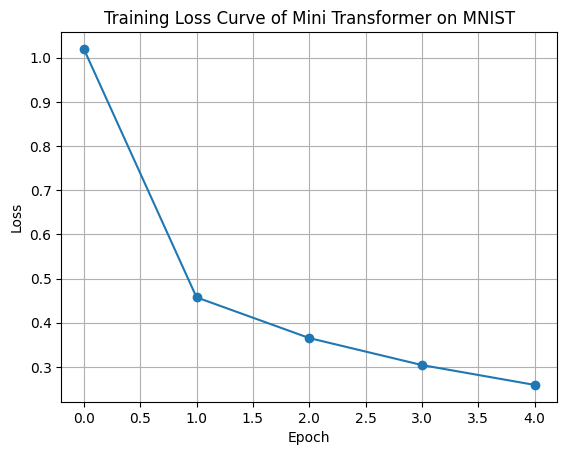

In [4]:
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve of Mini Transformer on MNIST")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


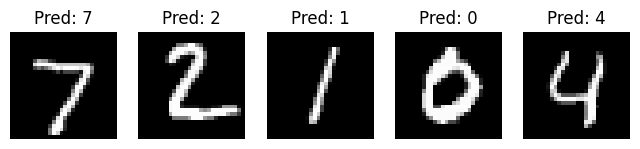

In [5]:
model.eval()

examples = []
preds = []

with torch.no_grad():
    for img, label in test_loader:
        pred = model(img).argmax(dim=1)
        examples.extend(img[:5])
        preds.extend(pred[:5])
        break

plt.figure(figsize=(8,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(examples[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis("off")
plt.show()




### Inference pipeline:

1. Input image → flatten → sequence
2. Embedded + positional encoding added
3. Self-attention extracts relationships
4. Transformer layer aggregates knowledge
5. First token passed into classifier
6. Output probability → digit prediction

No gradients or parameter updates here.


## Interpretation

✔ Loss curve shows learning over epochs  
✔ Predictions validate inference correctness  
✔ Heatmap shows where attention focuses  
✔ 3D visualization helps understand structure

### Training Summary
The transformer optimized parameters by minimizing:

$$
- \log p_{\theta}(y|x)
$$

### Inference Summary
Prediction uses:

$$
\hat{y} = \text{softmax}(WZ_{cls})
$$

No gradients, only forward pass.

This illustrates how transformers learn internal representations useful for recognition tasks like MNIST.


## ✔ Completed Coverage

### Theory
✔ Definition  
✔ Mathematical derivation  

### Practice
✔ Training step-by-step  
✔ Inference flow  

### Visualization
✔ Training loss curve  
✔ Attention heatmaps  
✔ 3D visualization  
✔ Prediction visualization

This completes *Transformers: Training and Inference on MNIST*.
